# Tumor - Epithelium Compartment Trajectory Analyses

###### Ethan Earlie ... 2/10/2025

## Import Jobs

In [25]:
import pandas as pd
import numpy as np
import scanpy as sc
#import scvelo as scv
import cellrank as cr
#import dynamo as dyn
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
import matplotlib.patches as patches
import plotly.express as px

import matplotlib as mpl
import matplotlib
from matplotlib import rcParams
from adjustText import adjust_text
from scipy.stats import zscore
from copy import deepcopy
from kneed.knee_locator import KneeLocator
from sklearn.metrics.cluster import adjusted_rand_score
from py_pcha.PCHA import PCHA
from skimage import filters
from scipy import stats
from pprint import pprint

import palantir
import scipy
import sys
import os
import glob
import anndata
import itertools
import phenograph
import sklearn
import scanorama
import scikit_posthocs
import slepc4py
import petsc4py
import fastcluster

from os import path
from pathlib import Path
from scipy.ndimage.filters import convolve

In [28]:
output_dir = '/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/'
git_dir = '/workdir/analysis_pipeline'
!mkdir -p {output_dir}
print(f'output_dir: {output_dir}')
print(f'git_dir: {git_dir}')
run_in_background_wait_default=True

output_dir: /workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225/
git_dir: /workdir/analysis_pipeline


In [29]:
boolean_to_color = {True:'crimson',False:'steelblue'}

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_result { max-width:85% !important; }</style>"))

In [30]:
%matplotlib inline

sc.settings.figdir = output_dir

sc.set_figure_params(dpi=80, dpi_save=400)

matplotlib.style.use('default')
#scv.settings.set_figure_params('scanpy')
sns.set_style('white')

#scv.settings.verbosity = 3
#scv.settings.set_figure_params("scvelo")
#scv.settings.figdir = output_dir

cr.settings.verbosity = 2
cr.settings.figdir = output_dir

In [31]:
plt.rcParams['figure.figsize']=(6,4) #rescale figures
sc.settings.verbosity = 4

In [32]:
def flatten(l):
    if all(isinstance(x, list) for x in l):
        return [item for sublist in l for item in sublist]
    elif all(isinstance(x, np.ndarray) for x in l):
        return [item for sublist in l for item in sublist]
    else:
        return 'Input List is Not Nested'

In [33]:
# run bash command in background if stdoutfile does not exist. If it does, output contents of stdoutfile.
# If force=true, overwrite and re-run command.
def run_in_background(command, stdoutfile, stderrfile="", force=False, quiet=False, 
                      wait=run_in_background_wait_default):
    if force or not path.exists(stdoutfile):
        command = 'bash -c \'' + command + '\' > ' + stdoutfile
        if stderrfile:
            command = command + ' 2>' + stderrfile
        else:
            command = command + ' 2>&1'
        if not wait:
            command = command + ' &'
        print('calling ' + command + '\n')
        os.system(command)
    else:
        wait=True
    if wait:
        if not quiet:
            print("Output from stdout file " + stdoutfile)
            !cat {stdoutfile}
        else:
            print("Output from stdout file " + stdoutfile + " is suppressed")
        if stderrfile and path.exists(stderrfile):
            print("Output from stderr file " + stderrfile)
            !cat {stderrfile}
            
            
def filter_genes(adata, minCell):
    hasCell = adata.layers['X'] > 0
    numCell = np.array(hasCell.sum(axis=0))
    tooSmall = [i < minCell for i in numCell]
    is_invalid = np.zeros(adata.shape[1], np.bool)
    is_invalid[np.where(tooSmall)[0]] = True
    print(f"Removing {np.sum(is_invalid)} out of {len(is_invalid)} genes with less than {minCell} cells")
    adata.var['n_cells_by_counts'] = numCell
    return is_invalid


def my_run_mast(cond1, cond2, infile=None, data_field='logX', hvg_filter='TRUE', sample_covariate='FALSE', cell_filter='FALSE',  
                readonly=False, wait=True, force=False, plot=True, num_cores=30,
                use_filter=None, xlabel_cutoff=0.1, groupName='condition', reverse=False,
                sortBy='scaled_rank_score', quiet=False, mast_outdir=None, outname_str="", num_label=30):

    if use_filter is None:
        filterExt=''
        filterGenes=None
        filterName=''
    else:
        filterExt=use_filter['ext']
        filterGenes=use_filter['genes']
        filterName=' ( ' + use_filter['name'] + ')'
        
    if groupName == 'geneExpression':
        mast_outdir = f'{output_dir}/MAST-geneExp/{cond1}'.replace('cellType ', '_')
        outname = f'{cond1}_geneExp{cond2}_{outname_str}'.replace(' ', '_')
    else:
        if mast_outdir == None:
            mast_outdir = f'{output_dir}/{cond1}_vs_{cond2}/MAST'.replace(' ', '_')
            
    outname=f'{cond1}_vs_{cond2}_{outname_str}'.replace(' ', '_')
            
    stdoutfile=f"{mast_outdir}/stdout{outname_str}.txt"
    outfile = f"{mast_outdir}/{outname}.csv"
    plotfile = f"{mast_outdir}/{outname}{filterExt}.png".replace(' ', '_')
    
    if not readonly:
        if (infile is None):
            print("No infile (h5ad) given! Cannot run MAST.")
            return(None)
        if not path.exists(outfile):
            if not force:
                print(f"{outfile} not found, setting force to True")
            force=True
        !cp {git_dir}/scripts/MAST_new.R /root/scripts/
        cmd=f'mkdir -p "{mast_outdir}"'
        !{cmd}
        outname_arg=""
        
        if outname_str != "":
            outname_arg=f"--outname-str \"{outname_str}\""
            
        cmd=f'R --vanilla --args --infile "{infile}" --data_field "{data_field}" --outdir "{mast_outdir}" --hvg_filter "{hvg_filter}" \
                 --sample_covariate "{sample_covariate}" --cell_filter "{cell_filter}" --groups {groupName} --comp-groups "{cond1}" "{cond2}"'
        cmd += f' --numcores {num_cores} {outname_arg} < /root/scripts/MAST_new.R'
        
        run_in_background(cmd, stdoutfile, force=force, wait=wait, quiet=quiet)
        
    if not path.exists(outfile):
        if (readonly):
            if not reverse:
                return(run_mast(cond2, cond1, infile=infile, readonly=True, plot=plot, use_filter=use_filter,
                               xlabel_cutoff=xlabel_cutoff, groupName=groupName, reverse=True, sortBy=sortBy))
            else:
                print("outfile " + outfile + " does not exist, returning")
        else:
            print(cmd + " has not finished, returning.")
        return(None)
    
    mastResults = read_mast_results(outfile, filterGenes, filterExt, reverse=reverse, sortBy=sortBy)
    
    if plot:
        plot_mast_results(mastResults, title='MAST results ' + ' ' + cond1 + ' vs ' + cond2 + filterName, 
                          num_label=num_label, arrows=True, fontsize=15, plot_outfile=plotfile, xlabel_cutoff=xlabel_cutoff)
    return(mastResults)

def read_mast_results(filename, filter_genes=None, filter_label='_filtered', reverse=False,
                      sortBy='scaled_rank_score'):
    print("Reading " + filename)
    mastResults = pd.read_csv(filename)
    mastResults.rename(index=str, columns={"primerid": "gene", "coef": "log2FC", 'Pr(>Chisq)':'p',
                                          'Pr..Chisq.':'p'}, inplace=True, errors='ignore')
    pmin= np.min(np.array([x for x in mastResults.p if x!=0]))
    fdrmin = np.min(np.array([x for x in mastResults.fdr if x!=0]))
    #mastResults.log2FC[np.isnan(mastResults.log2FC)] = np.nanmax(mastResults.log2FC)
    mastResults = mastResults[(np.isnan(mastResults['ci.lo']) == False) & (np.isnan(mastResults['ci.hi']) == False)]
    mastResults.drop(['Unnamed: 0'], axis=1, inplace=True)
    mastResults.set_index('gene', drop=True, inplace=True)
    mastResults['bonferroni'] = mastResults['p']*mastResults.shape[0]
    bonmin = np.min(np.array([x for x in mastResults.bonferroni if x!=0]))
    mastResults.loc[mastResults.p==0,'p'] = pmin
    mastResults.loc[mastResults.fdr==0,'fdr'] = fdrmin
    mastResults.loc[mastResults.bonferroni==0,'bonferroni'] = bonmin
    mastResults.loc[mastResults.bonferroni > 1,'bonferroni'] = 1
    mastResults['rank_score'] = -10*np.log10(mastResults['bonferroni'])*np.sign(mastResults['log2FC'])
    mastResults['FC'] = 2.0**mastResults['log2FC']
    mastResults['scaled_rank_score'] = mastResults['rank_score']*np.abs(mastResults['log2FC'])
    mastResults['abs_scaled_rank_score'] = np.abs(mastResults['scaled_rank_score'])
    if reverse:
        mastResults['log2FC'] = -mastResults['log2FC']
        mastResults['FC'] = 1.0/mastResults['FC']
        mastResults['ci.hi'] = -mastResults['ci.hi']
        mastResults['ci.lo'] = -mastResults['ci.lo']
        mastResults['rank_score'] = -mastResults['rank_score']
        mastResults['scaled_rank_score'] = -mastResults['scaled_rank_score']
    mastResults = mastResults.sort_values(by=sortBy, ascending=False)
    if filter_genes is not None:
        mastResults = mastResults.loc[[g for g in mastResults.index if g in filter_genes]]
        filename=os.path.splitext(filename)[0] + filter_label + '.csv'
        mastResults[['p', 'log2FC', 'FC', 'fdr', 'ci.hi','ci.lo','bonferroni','rank_score', 'scaled_rank_score']].to_csv(filename)
    return(mastResults)

def make_volcano_plot(df, title='MAST volcano plot', plot_outfile = None, 
                      ptype='bonferroni', mlog10_thresh=-np.log10(0.1), log2FC_thresh = np.log2(1.1),
                      num_label=15, arrows=True, 
                      fontsize=rcParams['font.size'],
                      figsize=(7,5),
                      axis_lines=False,
                      xlabel_cutoff=0.1,
                      minY=-1,
                      ycol='fdr',
                      xcol='log2FC',
                      xlabel='$log_2(FC)$',
                      ylabel='$-log{10}(p_{adj})$',
                      labelcol='index', 
                      label_list=None,
                      color_var=None,
                      cmap=None,
                      s=5, 
                      s_var=None,
                      color='r'):
    
    print("ptype:", ptype)
    print("ycol:", ycol)
    # Identify significant genes to highlightlabelle
    target_num_label = num_label
    num_label=500
    while num_label > target_num_label:
        f = ((df[ycol] < 0.05) & ((df[xcol] > xlabel_cutoff) | (df[xcol] < -xlabel_cutoff)) & (df[ptype] < 0.5))
        num_label = np.sum(f)
        if (num_label > target_num_label):
            xlabel_cutoff = xlabel_cutoff+0.01
    print(f"num_label={num_label}, xlabel_cutoff={xlabel_cutoff}")

    x = df[xcol].to_numpy()
    
    y = df[ptype].to_numpy()
    if (np.sum(y==0) > 0):
        y[y==0] = np.min(y[y!=0])/2
    y = -np.log10(abs(df[ptype].to_numpy()))*np.sign(df[ptype]).to_numpy()
    
    if label_list==None:
        sig_ind = np.where((np.abs(x) > log2FC_thresh) * (np.abs(y) > mlog10_thresh))[0]    
        f = sig_ind
        
    else:
        if labelcol=='index':
            sig_ind = np.array(df.index.map(lambda x: x in label_list)).astype(bool)
        else:
            sig_ind = np.array(df[labelcol].map(lambda x: x in label_list)).astype(bool)
        f = np.where((np.abs(x) > log2FC_thresh) * (np.abs(y) > mlog10_thresh))[0]  
        
    fig, ax = plt.subplots(figsize=figsize)
    
    # Make Volcano plot
    if s_var != None:
        
        s_var = df[s_var].to_numpy()
        
        plt.scatter(x, y, s=[10*x for x in s_var], c='k')
        
        if color_var == None:
            plt.scatter(x[sig_ind], y[sig_ind], s=[10*x for x in s_var[sig_ind]], c=color)
        else:
            if cmap == None:
                print('No cmap provided.')
            else:
                plt.scatter(x[sig_ind], y[sig_ind], s=[10*x for x in s_var[sig_ind]], c=df[color_var].values, cmap=cmap)
    else:
        plt.scatter(x, y, s=s, c='k')
        
        if color_var == None:
            plt.scatter(x[sig_ind], y[sig_ind], s=s, c=color)
        else:
            if cmap == None:
                print('No cmap provided.')
            else:
                plt.scatter(x[sig_ind], y[sig_ind], s=s, c=df[color_var].values, cmap=cmap)
        
    plt.title(title, fontsize=14)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.xlabel(xlabel, size=14, weight='normal')
    plt.ylabel(ylabel, size=14, weight='normal')
    #maxX = np.nanmax(np.append(np.abs(x), 1.5))
    #maxY = np.nanmax(np.append(y, 350))
    maxX = np.nanmax(np.abs(x))
    maxY = np.nanmax(y)
    plt.xlim(-maxX-0.5, maxX+0.5)
    plt.ylim(minY, maxY*1.1)
    plt.grid(b=None)
    sns.despine()
    ax=plt.gca()
    ax.grid(False)
    
    if axis_lines:
        plt.vlines(x=0, ymin=minY, ymax=maxY+100, linestyles='dashed', color='grey')
        plt.hlines(y=0, xmin=-maxX-1, xmax=maxX+1, linestyles='dashed', color='grey')
    
    #f = (df['fdr'] < 0.01) & ((df['log2FC'] > 0.2) | (df['log2FC'] < -0.2))
    if labelcol == 'index':
        z = sorted(zip(y[f], x[f], df.index[f]), reverse=True)
    else:
        z = sorted(zip(y[f], x[f], df[labelcol][f]), reverse=True)
        
    
    if label_list==None:
        if num_label > 0:
    #        z=sorted(zip(y,x,df.index), reverse=True)[:num_label]
            texts = []
            for i in range(len(z)):
                texts.append(ax.text(z[i][1], z[i][0], z[i][2], fontsize=fontsize))
            if (arrows):
                niter=adjust_text(texts, x=x, y=y, 
                                  #force_text=(0.5,0.5),
                                  #force_points=(0.5,0.5),
                                  #expand_text=(2,2),
                                  #expand_points=(2,2),
                                  #autoalign='x',
                                  precision=0.001,
                                  arrowprops=dict(arrowstyle='-|>', color='gray', lw=0.5))
            else:
                niter = adjust_text(texts, x=x, y=y, force_text=0.05)
            #print("niter=" + str(niter))
        
    else:
        z = [x for x in z if x[2] in label_list]
            
        #print(z)
        
        texts = []
        for i in range(len(z)):
            texts.append(ax.text(z[i][1], z[i][0], z[i][2], fontsize=fontsize))
        if (arrows):
            niter=adjust_text(texts, x=x, y=y, 
                              #force_text=(0.5,0.5),
                              #force_points=(0.5,0.5),
                              #expand_text=(2,2),
                              #expand_points=(2,2),
                              #autoalign='x',
                              precision=0.001,
                              arrowprops=dict(arrowstyle='-|>', color='gray', lw=0.5))
        else:
            niter = adjust_text(texts, x=x, y=y, force_text=0.05)

    
    # SAVE FIGURE
    if plot_outfile is not None:
        d = os.path.dirname(plot_outfile)
        if not os.path.exists(d):
            os.makedirs(d)
        plt.savefig(plot_outfile, bbox_inches='tight', dpi=400)
        print("Wrote " + plot_outfile)
    plt.show()
    
# Get Mouse to Human Gene Mapping from Melissa:
adata_mToH_mapping = sc.read('/workdir/CIN_TME/data/adata_pre_deg_FROM_MELISSA.h5ad')

mToH_mapping = {}
for i in adata_mToH_mapping.var.index:
    mToH_mapping[i] = adata_mToH_mapping.var.loc[i,'humanGene']
    
del adata_mToH_mapping

In [34]:
def run_gsea(rank, output_root, fdr_cutoff=0.25, label='GSEA run', force=False, wait=False,
            gmtfile=f'{git_dir}/data/merged_genesets.gmt', return_command_only=False,
            readonly=False, gene_map=None):
    label = label.replace(" ", "_")
    
    # look to see if output folder already exists
    if return_command_only and not force:
        f = glob.glob(output_root + "/**/*gsea_report*pos*tsv", recursive=True)
        if len(f):
            return None
    if not readonly:
        Path(output_root).mkdir(parents=True, exist_ok=True)
    rnkFile=f'{output_root}/input.rnk'
    if rank is not None:
        if gene_map is not None:
            rank = pd.DataFrame(rank)
            rank['hgene'] = [("" if i.upper() in gene_map.values() else i.upper()) if i not in gene_map else gene_map[i] for i in rank.index]            
            droprows = (rank['hgene'] == '')
            print(f'Dropping {sum(droprows)} results with no human gene mapping')
            rank = rank.loc[~droprows]
            rank.set_index('hgene', inplace=True)
        else:
            rank.index = [i.upper() for i in rank.index]
        rank.to_csv(rnkFile, sep='\t', header=False, index=True)
    cmd=f'/workdir/CIN_TME/GSEA_4.1.0/gsea-cli.sh GSEAPreranked -rnk {rnkFile} -gmx {gmtfile} -collapse No_Collapse -mode Max_probe -norm meandiv'
    cmd += f' -nperm 10000 -scoring_scheme weighted -rpt_label {label} -create_svgs true -include_only_symbols true'
    cmd += f' -make_sets true -plot_top_x 20 -rnd_seed 888 -set_max 1500 -set_min 1 -zip_report false -out {output_root}'
    if return_command_only:
        return(cmd)
    stdoutfile=f'{output_root}/{label}_stdout.txt'
    if not readonly:
        run_in_background(cmd,f'{output_root}/{label}_stdout.txt',  wait=wait, force=force, quiet=True)
    # recover information from run
    f = glob.glob(output_root + "/**/*gsea_report*pos*tsv", recursive=True)
    #print(f, output_root + "/**/*gsea_report*pos*tsv")
    if f is None:
        raise RuntimeError(
            'seqc.JavaGSEA was not able to recover the output of the Java '
            'executable. This likely represents a bug.')
    f.sort(key=os.path.getmtime)
    f = f[0]
    f2 = f.replace('_pos_', '_neg_')
    if not path.exists(f2):
        raise RuntimeError("Error finding neg result file for GSEA " + f2)
    names = ['name', 'size', 'es', 'nes', 'p', 'fdr_q', 'fwer_p', 'rank_at_max', 'leading_edge']
    pos = pd.read_csv(f, sep='\t', infer_datetime_format=False, parse_dates=False).iloc[:, :-1]
    pos.drop(['GS<br> follow link to MSigDB', 'GS DETAILS'], axis=1, inplace=True)
    
    neg = pd.read_csv(f2, sep='\t', infer_datetime_format=False, parse_dates=False).iloc[:, :-1]
    neg.drop(['GS<br> follow link to MSigDB', 'GS DETAILS'], axis=1, inplace=True)
    pos.columns, neg.columns = names, names
    pos['direction'] = 'pos'
    neg['direction'] = 'neg'
    aa = pos.sort_values('fdr_q', ascending=True).fillna(0)
    bb = neg.sort_values('fdr_q', ascending=True).fillna(0)
    aa = aa[aa['fdr_q'] <= fdr_cutoff]
    bb = bb[bb['fdr_q'] <= fdr_cutoff]
    outcsv = f'{output_root}/{label}.csv'.replace(' ', '_')
    aa.to_csv(outcsv, sep='\t', index=False)
    with open(outcsv, 'a') as f:
        f.write('\n')
    bb.to_csv(outcsv, sep='\t', index=False, mode='a')
    return(pos.append(neg))


def gsea_linear_scale(data: pd.Series) -> pd.Series:
        """scale input vector to interval [-1, 1] using a linear scaling
        :return correlations: pd.Series, data scaled to the interval [-1, 1]
        """
        data = data.copy()
        data -= np.min(data, axis=0)
        data /= np.max(data, axis=0) / 2
        data -= 1
        return data

# Get Mouse to Human Gene Mapping from Melissa:
adata_mToH_mapping = sc.read('/workdir/CIN_TME/data/adata_pre_deg_FROM_MELISSA.h5ad')

mToH_mapping = {}
for i in adata_mToH_mapping.var.index:
    mToH_mapping[i] = adata_mToH_mapping.var.loc[i,'humanGene']
    
del adata_mToH_mapping

In [35]:
# compute entropy of 'factor' among n_neighbors nearest neighbors for each cell, store in adata.obs[outname]
def compute_entropy(adata, n_neighbors=30, neighbors_key='neighbors', plotHist=True, factor='sample', outname='entropy', 
                    compute_pca=True, compute_neighbors=True):

    print(neighbors_key)
    
    if compute_pca==True:
        print('Computing PCA. If X_pca already present, set compute_pca=False')
        sc.tl.pca(adata)
    
    if compute_neighbors==True:
        print('Computing nearest neighbors. If neighbors already present, set compute_neighbors=False')
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, key_added=f'neighbors_{n_neighbors}', n_pcs=adata.obsm['X_pca'].shape[1])
        
    shannonD = lambda x: np.nansum(-x*np.log(x))
    adata.obs[outname] = [shannonD(adata.obs[factor][adata.obsp[f'{neighbors_key}_distances'][i,:].nonzero()[1]].\
                                   value_counts(normalize=True))
                            for i in range(adata.shape[0])]
    if plotHist:
        plt.hist(adata.obs[outname], edgecolor='white')
        
# compute entropy of factor among n_neighbors nearest neighbors in same group factor2 for each cell, 
# store in adata.obs[outname]
def compute_entropy2(adata, n_neighbors=30, plotHist=False, factor='sample', factor2='condition', 
                     outname='entropy-condition'):
    adata.obs[outname]=-1
    f2s = list(adata.obs[factor2].value_counts().index)
    for f2 in f2s:
        f = adata.obs[factor2] == f2
        a2 = adata[f,].copy()
        compute_entropy(a2, n_neighbors=n_neighbors, neighbors_key=f'neighbors_{n_neighbors}', factor=factor, outname=outname, plotHist=plotHist,
                        compute_pca=True, compute_neighbors=True)
        adata.obs.loc[f,outname] = a2.obs[outname]

In [36]:
import scvelo.logging as logg
import scvelo.settings as settings
from scvelo.tools.transition_matrix import transition_matrix
from scvelo.tools.utils import norm
from scvelo.tools.velocity_embedding import quiver_autoscale
import warnings

def my_velocity_embedding(
    data,
    basis=None,
    vkey="velocity",
    scale=10,
    self_transitions=True,
    use_negative_cosines=True,
    direct_pca_projection=None,
    retain_scale=False,
    autoscale=True,
    all_comps=True,
    T=None,
    copy=False,
):
    """Projects the single cell velocities into any embedding.
    Given normalized difference of the embedding positions
    :math:`\\tilde \\delta_{ij} = \\frac{x_j-x_i}{\\left\\lVert x_j-x_i \\right\\rVert}`.
    the projections are obtained as expected displacements with respect to the
    transition matrix :math:`\\tilde \\pi_{ij}` as
    .. math::
        \\tilde \\nu_i = E_{\\tilde \\pi_{i\\cdot}} [\\tilde \\delta_{i \\cdot}]
        = \\sum_{j \\neq i} \left( \\tilde \\pi_{ij} - \\frac1n \\right) \\tilde \\delta_{ij}.
    Arguments
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    basis: `str` (default: `'tsne'`)
        Which embedding to use.
    vkey: `str` (default: `'velocity'`)
        Name of velocity estimates to be used.
    scale: `int` (default: 10)
        Scale parameter of gaussian kernel for transition matrix.
    self_transitions: `bool` (default: `True`)
        Whether to allow self transitions, based on the confidences of transitioning to
        neighboring cells.
    use_negative_cosines: `bool` (default: `True`)
        Whether to project cell-to-cell transitions with negative cosines into
        negative/opposite direction.
    direct_pca_projection: `bool` (default: `None`)
        Whether to directly project the velocities into PCA space,
        thus skipping the velocity graph.
    retain_scale: `bool` (default: `False`)
        Whether to retain scale from high dimensional space in embedding.
    autoscale: `bool` (default: `True`)
        Whether to scale the embedded velocities by a scalar multiplier,
        which simply ensures that the arrows in the embedding are properly scaled.
    all_comps: `bool` (default: `True`)
        Whether to compute the velocities on all embedding components.
    T: `csr_matrix` (default: `None`)
        Allows the user to directly pass a transition matrix.
    copy: `bool` (default: `False`)
        Return a copy instead of writing to `adata`.
    Returns
    -------
    Returns or updates `adata` with the attributes
    velocity_basis: `.obsm`
        coordinates of velocity projection on embedding
    """
    adata = data.copy() if copy else data

    if basis is None:
        keys = [
            key for key in ["pca", "tsne", "umap"] if f"X_{key}" in adata.obsm.keys()
        ]
        if len(keys) > 0:
            basis = "pca" if direct_pca_projection else keys[-1]
        else:
            raise ValueError("No basis specified")

    if f"X_{basis}" not in adata.obsm_keys():
        raise ValueError("You need to compute the embedding first.")

    if direct_pca_projection and "pca" in basis:
        logg.warn(
            "Directly projecting velocities into PCA space is for exploratory analysis on principal components.\n"
            "         It does not reflect the actual velocity field from high dimensional gene expression space.\n"
            "         To visualize velocities, consider applying `direct_pca_projection=False`.\n"
        )

    logg.info("computing velocity embedding", r=True)

    V = np.array(adata.layers[vkey])
    vgenes = np.ones(adata.n_vars, dtype=bool)
    if f"{vkey}_genes" in adata.var.keys():
        vgenes &= np.array(adata.var[f"{vkey}_genes"], dtype=bool)
    vgenes &= ~np.isnan(V.sum(0))
    V = V[:, vgenes]

    if direct_pca_projection and "pca" in basis:
        PCs = adata.varm["PCs"] if all_comps else adata.varm["PCs"][:, :2]
        PCs = PCs[vgenes]

        X_emb = adata.obsm[f"X_{basis}"]
        V_emb = (V - V.mean(0)).dot(PCs)

    else:
        X_emb = (
            adata.obsm[f"X_{basis}"] if all_comps else adata.obsm[f"X_{basis}"][:, :2]
        )
        V_emb = np.zeros(X_emb.shape)

        T = (
            transition_matrix(
                adata,
                vkey=vkey,
                scale=scale,
                self_transitions=self_transitions,
                use_negative_cosines=use_negative_cosines,
            )
            if T is None
            else T
        )
        T.setdiag(0)
        T.eliminate_zeros()

        densify = adata.n_obs < 1e4
        TA = T.A if densify else None

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            print(adata.n_obs)
            
            for i in range(adata.n_obs):
                
                #print(T[i].shape)
                
                
                #print(T[i].indices)
                
                indices = T[i].indices
                
                #print(indices.shape)
                #print(X_emb.shape)
                #print(X_emb[indices].shape)
                
                dX = X_emb[indices] - X_emb[i, None]  # shape (n_neighbors, 2)
                
                #print(dX.shape)
                
                if not retain_scale:
                    dX /= norm(dX)[:, None]
                
                #print(dX.shape)
                #print(np.isnan(dX))
                
                #print(dX[np.isnan(dX)])
                
                dX = np.nan_to_num(dX)       # zero diff in a steady-state
                
                probs = TA[i, indices] if densify else T[i].data
                V_emb[i] = probs.dot(dX) - probs.mean() * dX.sum(0)

        if retain_scale:
            X = (
                adata.layers["Ms"]
                if "Ms" in adata.layers.keys()
                else adata.layers["spliced"]
            )
            delta = T.dot(X[:, vgenes]) - X[:, vgenes]
            if scipy.sparse.issparse(delta):
                delta = delta.A
            cos_proj = (V * delta).sum(1) / norm(delta)
            V_emb *= np.clip(cos_proj[:, None] * 10, 0, 1)

    if autoscale:
        V_emb /= 3 * quiver_autoscale(X_emb, V_emb)

    if f"{vkey}_params" in adata.uns.keys():
        adata.uns[f"{vkey}_params"]["embeddings"] = (
            []
            if "embeddings" not in adata.uns[f"{vkey}_params"]
            else list(adata.uns[f"{vkey}_params"]["embeddings"])
        )
        adata.uns[f"{vkey}_params"]["embeddings"].extend([basis])

    vkey += f"_{basis}"
    adata.obsm[vkey] = V_emb

    logg.info("    finished", time=True, end=" " if settings.verbosity > 2 else "\n")
    logg.hint("added\n" f"    '{vkey}', embedded velocity vectors (adata.obsm)")

    return adata if copy else None

In [37]:
%pip freeze

adjustText==0.7.3
aiohttp==3.8.4
aiosignal==1.3.1
anndata==0.8.0
anndata2ri==1.0.6
annoy==1.17.0
appdirs==1.4.4
arboreto==0.1.6
argon2-cffi==20.1.0
asn1crypto==0.24.0
async-generator==1.10
async-timeout==4.0.2
asynctest==0.13.0
attrs==21.2.0
backcall==0.2.0
beautifulsoup4==4.9.3
biofluff==3.0.4
biopython==1.81
bioservices==1.7.11
biothings-client==0.3.0
bleach==3.3.0
bokeh==2.4.3
boltons==23.0.0
cached-property==1.5.2
cellrank==1.5.1
certifi==2018.1.18
cffi==1.14.5
chardet==3.0.4
charset-normalizer==3.1.0
click==8.0.1
cloudpickle==2.2.1
cmake==3.18.2
cmocean==2.0
colorama==0.4.4
colorlog==5.0.1
compress-json==1.0.8
configparser==5.3.0
cryptography==2.1.4
ctxcore==0.2.0
cycler==0.10.0
Cython==0.29.23
cytoolz==0.12.1
dask==2022.2.0
dateparser==1.1.8
decorator==4.4.2
defusedxml==0.7.1
dill==0.3.4
diskcache==5.6.3
distributed==2022.2.0
distro-info===0.18ubuntu0.18.04.1
docrep==0.3.2
doubletdetection==3.0
easydev==0.11.1
entrypoints==0.3
environments-utils==1.0.10
et-xmlfile==1.1.0
fa2==0.3

## Import Data

In [85]:
# This h5ad file can be found for download through GEO here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE248202

adata_FULL = sc.read('/workdir/varmus_single_cell/data/NOBACKUP/Gardner_et-al-2023_processed_adata_histological_transformation_subset.h5ad')
adata_HVG = adata_FULL[:,adata_FULL.var['highly_variable'] == True].copy()

### FDL Projections

In [41]:
adata_HVG.obs['sample'].unique()

['ERPMT_pool', 'ERPMT_doxMRD', 'ERPMT_3moMRD', 'transformed_SCLC', 'AT2_1mo']
Categories (5, object): ['AT2_1mo', 'ERPMT_3moMRD', 'ERPMT_doxMRD', 'ERPMT_pool', 'transformed_SCLC']

In [42]:
sample_cmap = {'AT2_1mo': '#AD0404', 
               'ERPMT_pool': '#ff0000', 
               'ERPMT_doxMRD': '#E896D1', 
               'ERPMT_3moMRD': '#9012F1', 
               'transformed_SCLC': '#46A8FF', def st
               'RPMT_pool': '#0432ff',
               'ERPMT_MRDrestart': '#d2b14c'}

adata_FULL.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_FULL.obs['sample'].unique())]
adata_HVG.uns['sample_colors'] = [sample_cmap[x] for x in sorted(adata_HVG.obs['sample'].unique())]

In [43]:
sorted(adata_FULL.obs['sample'].unique())

['AT2_1mo', 'ERPMT_3moMRD', 'ERPMT_doxMRD', 'ERPMT_pool', 'transformed_SCLC']

In [44]:
sc.settings.figdir

PosixPath('/workdir/varmus_single_cell/merged_pipeline_out/RD_Krt17_0225')

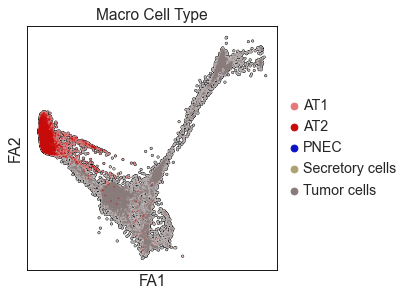

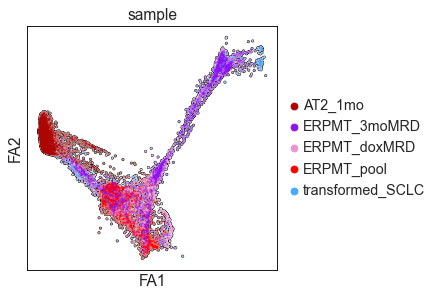

In [45]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.draw_graph(adata_HVG, 
                 color='Macro Cell Type', 
                 s=10,
                 alpha=0.5,
                 add_outline=True)

sc.pl.draw_graph(adata_HVG, 
                 color='sample', 
                 s=10,
                 alpha=0.5,
                 add_outline=True,
                 save='_sample_FDR.png')

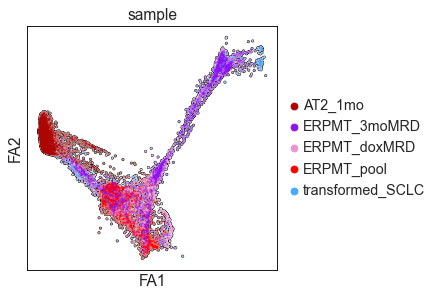

In [46]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

sc.pl.draw_graph(adata_HVG, 
                 color='sample', 
                 s=10,
                 alpha=0.5,
                 add_outline=True,
                 save='_sample_FDR.svg')

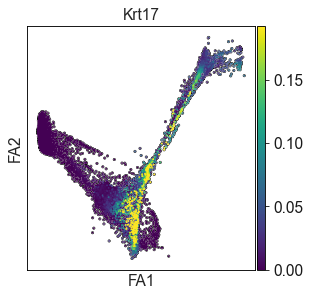

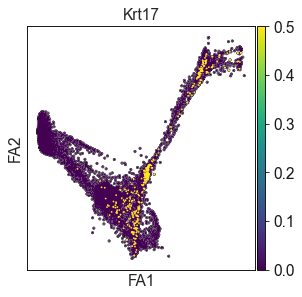

In [47]:
sc.settings.verbosity = 4
sc.set_figure_params(dpi=80, dpi_save=300) 

adata_FULL.X = adata_FULL.layers['X_impute']

sc.pl.draw_graph(adata_FULL, 
                 color='Krt17', 
                 s=10,
                 alpha=1,
                 cmap='viridis',
                 add_outline=True,
                 vmin='p02', vmax='p98',
                 save='_Krt17_imputed_FDL.svg')

adata_FULL.X = adata_FULL.layers['logX']

sc.pl.draw_graph(adata_FULL, 
                 color='Krt17', 
                 s=10,
                 alpha=1,
                 cmap='viridis',
                 add_outline=True,
                 vmin=0, vmax=0.5,
                 save='_Krt17_logX_FDL.svg')

### Interpret CellRank Results

In [50]:
subclusters = 'sample'

#### Gene Trends

In [87]:
adata_HVG.obsm['to_terminal_states_original'] = adata_HVG.obsm['to_terminal_states']
adata_HVG.obsm['to_terminal_states'] = cr.tl.Lineage(np.array(adata_HVG.obsm['to_terminal_states']),
                                                               names=['transformed_SCLC'],
                                                               colors=[sample_cmap['transformed_SCLC']])

In [ ]:
adata_HVG.obsm['to_terminal_states']

In [89]:
adata_FULL.obsm['to_terminal_states'] = adata_HVG.obsm['to_terminal_states']

##### Map Results to Full Gene adata

In [90]:
for col in adata_HVG.uns['macrostate_names']:
    
    adata_FULL.obs[f'{col}_macrostate_probs'] = adata_HVG[adata_FULL.obs.index].obs[f'{col}_macrostate_probs']

In [91]:
adata_FULL.obs[f'initial_states_probs'] = adata_HVG[adata_FULL.obs.index].obs[f'initial_states_probs']
adata_FULL.obs[f'terminal_states_probs'] = adata_HVG[adata_FULL.obs.index].obs[f'terminal_states_probs']

adata_FULL.obs[f'palantir_pseudotime_1'] = adata_HVG[adata_FULL.obs.index].obs[f'palantir_pseudotime_1']
adata_FULL.obs[f'palantir_diff_score_1'] = adata_HVG[adata_FULL.obs.index].obs[f'palantir_diff_score_1']

In [92]:
for x in ['DC', 'T_fwd_draw_graph_fa',
          'from_initial_states', 'initial_states_memberships', 
          'schur_vectors_bwd', 'schur_vectors_fwd', 'terminal_states_memberships', 
          'to_terminal_states']:
    
    adata_FULL.obsm[x] = adata_HVG[adata_FULL.obs.index].obsm[x]

##### Visualize

###### X Impute

In [100]:
#adata_HVG.layers['X_impute_scaled'] = adata_HVG.layers['X_impute'] / adata_HVG.layers['X_impute'].max(axis=0)

mat = pd.DataFrame(adata_HVG.layers['X_impute'].copy())

for x in mat:
    v = mat[x]
    mat[x]  = (v - v.min()) / (v.max() - v.min())

adata_HVG.layers['X_impute_scaled'] = mat.values

adata_HVG.X = adata_HVG.layers['X_impute_scaled']

In [101]:
#adata_FULL.layers['X_impute_scaled'] = adata_FULL.layers['X_impute'] / adata_FULL.layers['X_impute'].max(axis=0)

mat = pd.DataFrame(adata_FULL.layers['X_impute'].copy())

for x in mat:
    v = mat[x]
    mat[x]  = (v - v.min()) / (v.max() - v.min())

adata_FULL.layers['X_impute_scaled'] = mat.values

adata_FULL.X = adata_FULL.layers['X_impute_scaled']

In [102]:
adata_HVG.X = adata_HVG.layers['X_impute_scaled']

model = cr.ul.models.GAM(adata_HVG)

adata_FULL.X = adata_FULL.layers['X_impute_scaled']

model_FULL = cr.ul.models.GAM(adata_FULL)

In [103]:
adata_FULL.X = adata_FULL.layers['X_impute']

model_FULL_unscaled = cr.ul.models.GAM(adata_FULL)

Computing trends using `1` core(s)


Missing Genes:  []


  0%|          | 0/4 [00:00<?, ?gene/s]

    Finish (0:00:01)
Plotting trends


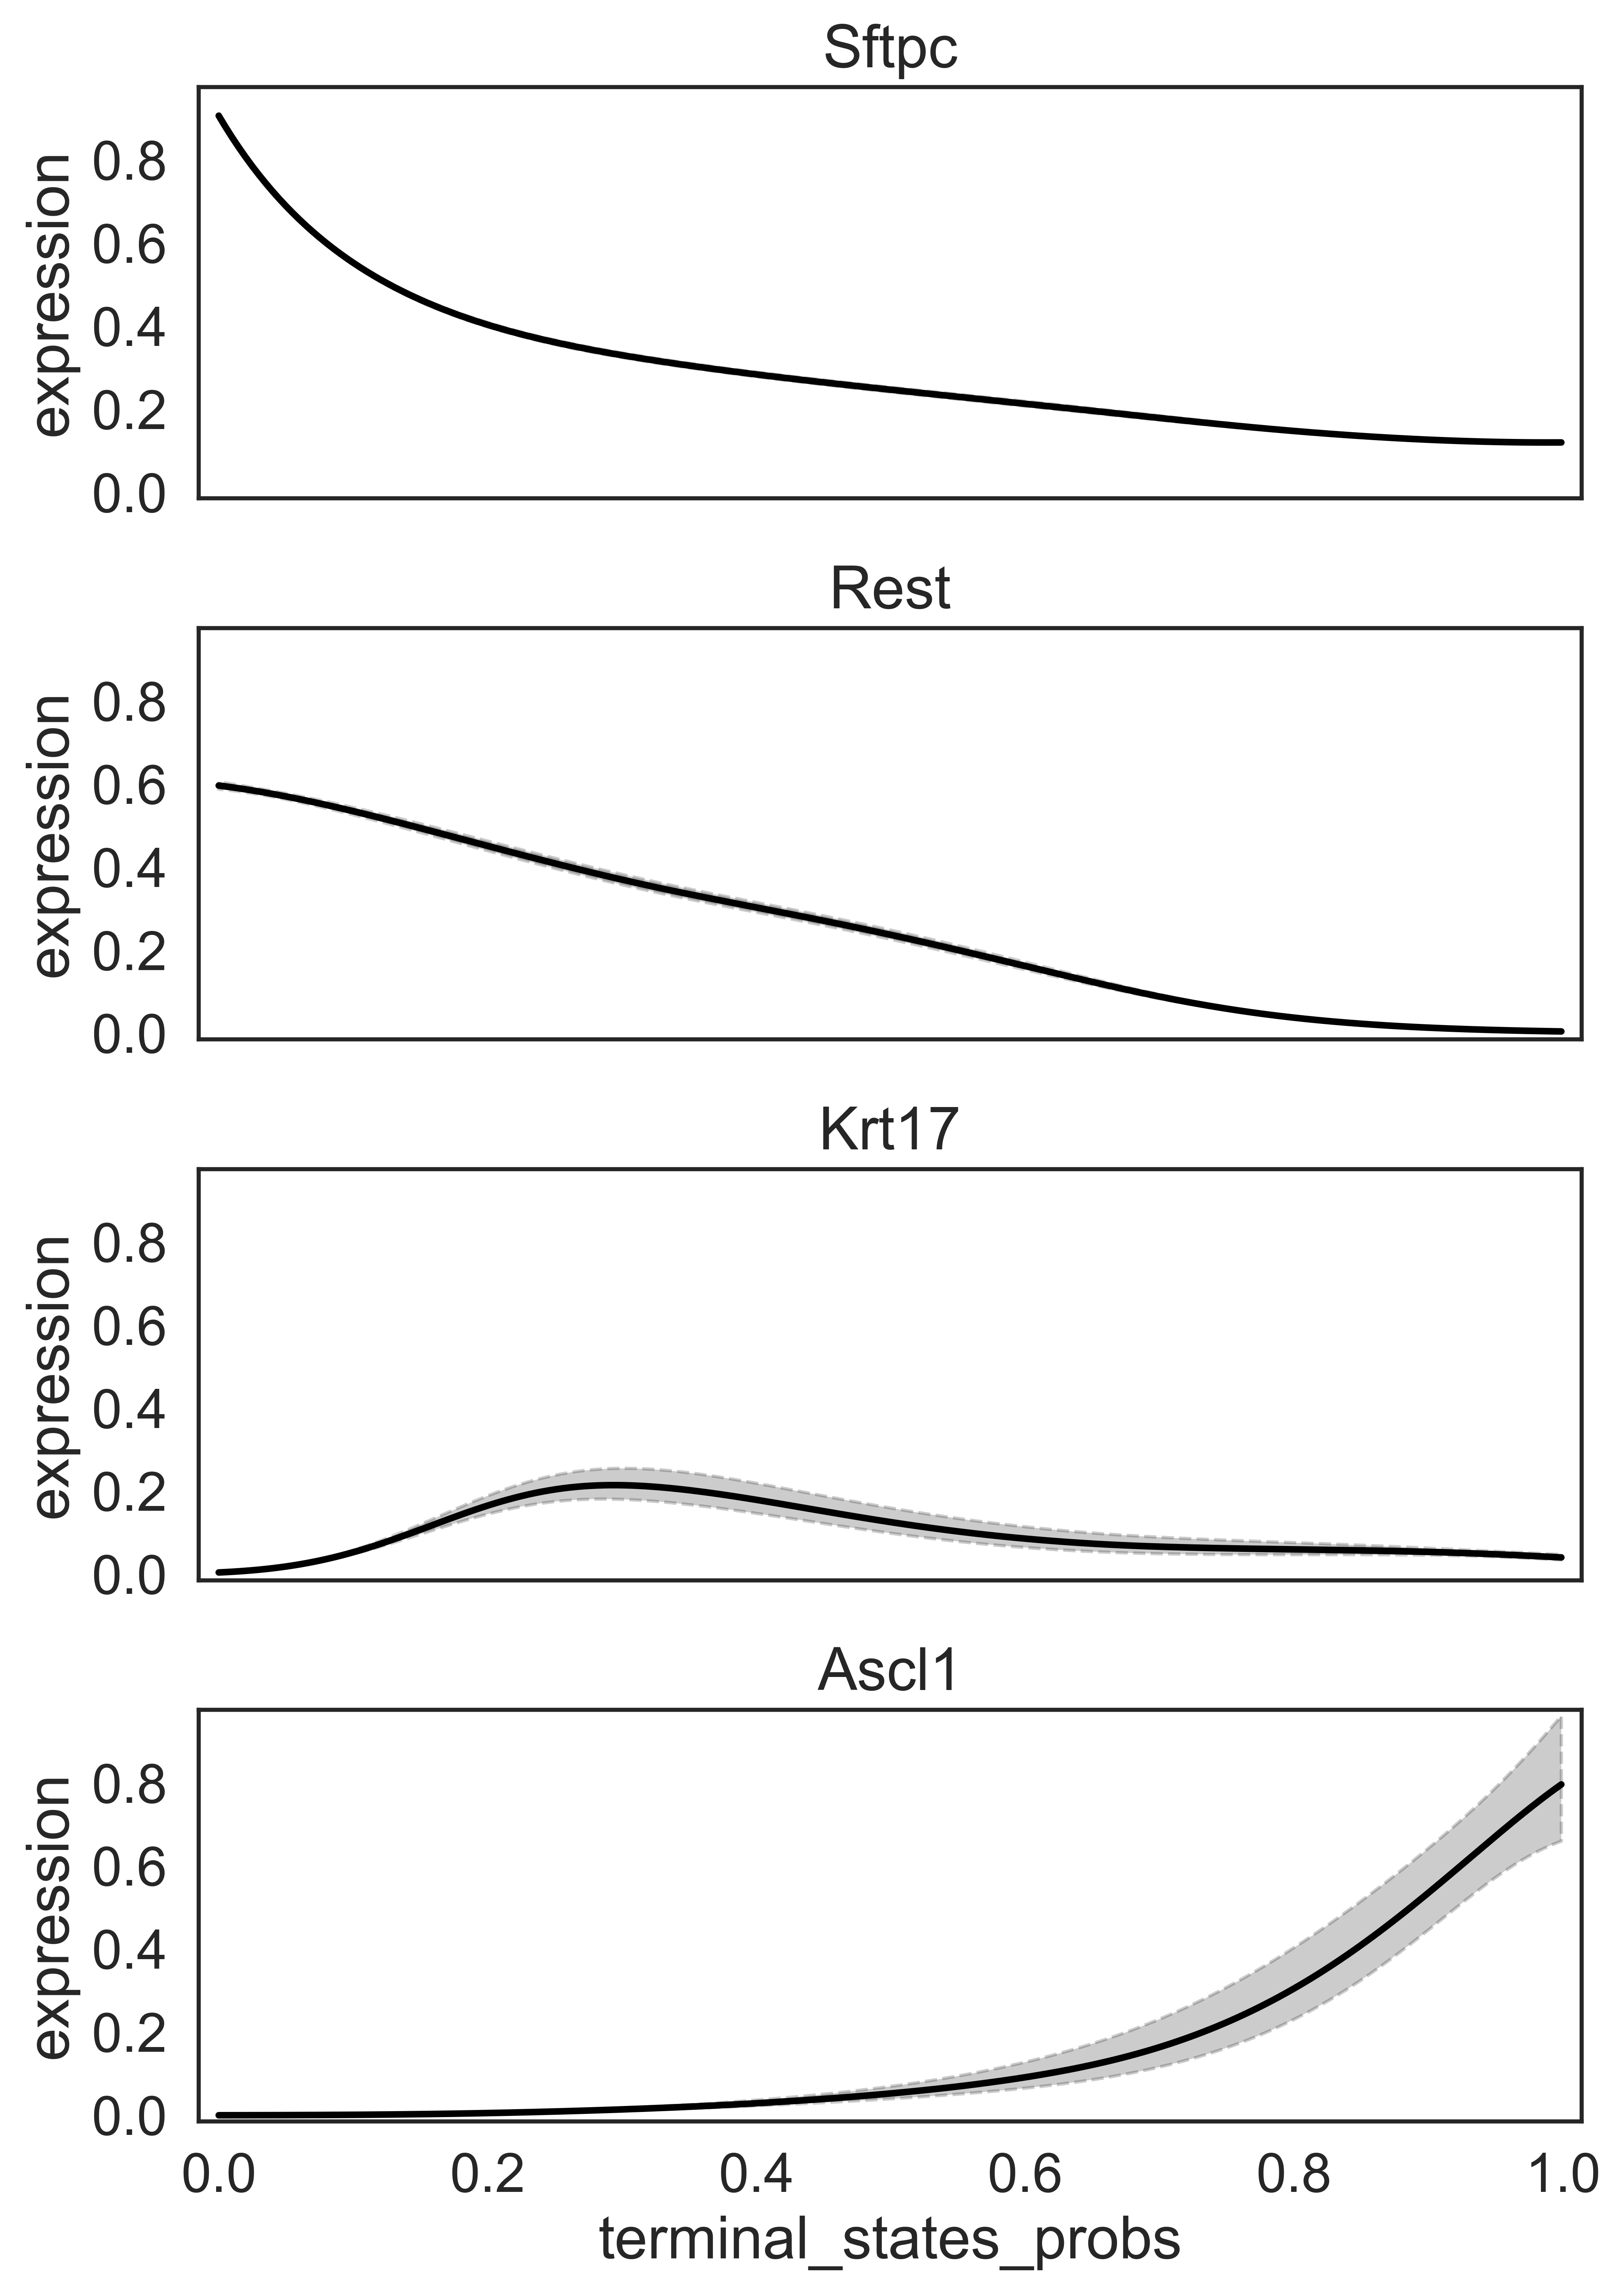

In [109]:
adata_FULL.X = adata_FULL.layers['X_impute_scaled']

sns.set(style='white', font_scale=1.5)

genes = ['Sftpc',
         'Rest',
         'Krt17',
         'Ascl1']

print('Missing Genes: ', [x for x in genes if x not in adata_FULL.var.index])

cr.pl.gene_trends(adata_FULL,
                  model=model_FULL_unscaled,
                  data_key="X",
                  genes=[x for x in genes if x in adata_FULL.var.index],
                  ncols=1,
                  time_key="terminal_states_probs",
                  lineages='transformed_SCLC',
                  same_plot=True,
                  hide_cells=True,
                  figsize=(7, 10),
                  n_test_points=200,
                  sharey=True,
                  legend_loc=None,
                  lineage_cmap=['#000000'],
                  dpi=600,
                  save=f'Select_Genes_Terminal_States_Probs_X_impute_scaled_matched_axis_Krt17_fig.svg')

sns.set(style='white', font_scale=1)